# Combining TCGA-PRAD, SU2C-PCF and GSE221601

This notebook combines the TCGA-PRAD, SU2C-PCF and GSE221601 datasets to create a larger dataset for prostate cancer.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
src_path: str = "../src"
sys.path.append(src_path)

In [4]:
from r_wrappers.sva import combat_seq

### Global Variables

In [5]:
TCGA_PRAD_SU2C_PCF_ROOT: Path = Path("/media/ssd/Perez/storage/TCGA_PRAD_SU2C_RNASeq")
GSE221601_ROOT: Path = Path("/media/ssd/Perez/storage/GSE221601")
TCGA_PRAD_SU2C_PCF_GSE221601_ROOT: Path = Path(
    "/media/ssd/Perez/storage/TCGA_PRAD_SU2C_PCF_GSE221601"
)
TCGA_PRAD_SU2C_PCF_GSE221601_ROOT.mkdir(exist_ok=True, parents=True)
(TCGA_PRAD_SU2C_PCF_GSE221601_ROOT / "data").mkdir(exist_ok=True, parents=True)

## 1. Load and merge annotation data from all datasets

### 1.1. TCGA-PRAD + SU2C-PCF

In [6]:
annot_df_tcga_prad_su2c_pcf = pd.read_csv(
    TCGA_PRAD_SU2C_PCF_ROOT / "data" / "samples_annotation_tcga_prad_su2c_clusters.csv",
    index_col=0,
)
display(annot_df_tcga_prad_su2c_pcf.head())

,patient_id,sample_type,file_name,release_year,sample_cluster,sample_cluster_no_replicates
sample_id,,,,,,
TCGA-EJ-A46I-01A,TCGA-EJ-A46I,PRIM,TCGA-EJ-A46I-01A.tsv,2022,PRIM,PRIM
TCGA-XK-AAJR-01A,TCGA-XK-AAJR,PRIM,TCGA-XK-AAJR-01A.tsv,2022,PRIM,PRIM
TCGA-KC-A4BV-01A,TCGA-KC-A4BV,PRIM,TCGA-KC-A4BV-01A.tsv,2022,PRIM,PRIM
TCGA-KC-A7F6-01A,TCGA-KC-A7F6,PRIM,TCGA-KC-A7F6-01A.tsv,2022,PRIM,PRIM
TCGA-YL-A8SI-01A,TCGA-YL-A8SI,PRIM,TCGA-YL-A8SI-01A.tsv,2022,PRIM,PRIM


In [7]:
annot_df_tcga_prad_su2c_pcf["sample_cluster_no_replicates"].value_counts()

sample_cluster_no_replicates
PRIM      500
MET_AA     67
MET_BB     57
NORM       52
MET_A      45
MET_B      41
ENDO       14
Name: count, dtype: int64

In [8]:
annot_df_tcga_prad_su2c_pcf = annot_df_tcga_prad_su2c_pcf[
    annot_df_tcga_prad_su2c_pcf["sample_cluster_no_replicates"].isin(("PRIM", "MET_BB"))
]
annot_df_tcga_prad_su2c_pcf["sample_cluster_no_replicates"] = (
    annot_df_tcga_prad_su2c_pcf["sample_cluster_no_replicates"].replace(
        "MET_BB", "MCRPC"
    )
)

### 1.2. GSE221601

In [9]:
annot_df_gse221601 = pd.read_csv(
    GSE221601_ROOT / "data" / "samples_annotation.csv", index_col=0
)
display(annot_df_gse221601.head())

,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,...,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,tissue,cluster_subtype
Run,,,,,,,,,,,,,,,,,,,,,
SRR22868605,RNA-Seq,200,3118990600,PRJNA915071,SAMN32372324,1397896683,"PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...",public,"fastq,run.zq,sra","gs,ncbi,s3",...,Homo sapiens,ILLUMINA,2024-07-31T00:00:00Z,2022-12-22T15:38:00Z,1,GSM6890182,Prostate cancer,SRP414492,Prostate cancer,Proliferation_low
SRR22868606,RNA-Seq,200,2437501200,PRJNA915071,SAMN32372325,1089843290,"PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...",public,"fastq,run.zq,sra","gs,ncbi,s3",...,Homo sapiens,ILLUMINA,2024-07-31T00:00:00Z,2022-12-22T15:25:00Z,1,GSM6890181,Prostate cancer,SRP414492,Prostate cancer,Proliferation_low
SRR22868607,RNA-Seq,200,4465919800,PRJNA915071,SAMN32372326,1924590452,"PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...",public,"fastq,run.zq,sra","gs,ncbi,s3",...,Homo sapiens,ILLUMINA,2024-07-31T00:00:00Z,2022-12-22T15:34:00Z,1,GSM6890180,Prostate cancer,SRP414492,Prostate cancer,NaN
SRR22868608,RNA-Seq,200,6239105400,PRJNA915071,SAMN32372327,2739084770,"PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...",public,"fastq,run.zq,sra","gs,ncbi,s3",...,Homo sapiens,ILLUMINA,2024-07-31T00:00:00Z,2022-12-22T15:38:00Z,1,GSM6890179,Prostate cancer,SRP414492,Prostate cancer,Proliferation_low
SRR22868609,RNA-Seq,200,7531102000,PRJNA915071,SAMN32372328,3294991515,"PRECISION ONCOLOGY, UROLOGY, SAMSUNG MEDICAL C...",public,"fastq,run.zq,sra","gs,ncbi,s3",...,Homo sapiens,ILLUMINA,2024-07-31T00:00:00Z,2022-12-22T15:41:00Z,1,GSM6890178,Prostate cancer,SRP414492,Prostate cancer,Proliferation_low


In [10]:
annot_df_gse221601["release_year"] = pd.to_datetime(
    annot_df_gse221601["ReleaseDate"]
).dt.year

### 1.3. Combine all annotation data into a common format

In [11]:
annot_df = pd.DataFrame(
    columns=["sample_id", "patient_id", "sample_type", "release_year"]
)

In [12]:
annot_df["sample_id"] = (
    annot_df_tcga_prad_su2c_pcf.index.tolist() + annot_df_gse221601.index.tolist()
)
annot_df["patient_id"] = (
    annot_df_tcga_prad_su2c_pcf["patient_id"].tolist()
    + annot_df_gse221601["BioSample"].tolist()
)
annot_df["sample_type"] = (
    annot_df_tcga_prad_su2c_pcf["sample_cluster_no_replicates"].tolist()
    + ["HSPC"] * annot_df_gse221601.shape[0]
)
annot_df["release_year"] = (
    annot_df_tcga_prad_su2c_pcf["release_year"].tolist()
    + annot_df_gse221601["release_year"].tolist()
)

In [13]:
annot_df.sort_values(by="sample_type", ascending=False).to_csv(
    TCGA_PRAD_SU2C_PCF_GSE221601_ROOT / "data" / "samples_annotation.csv", index=False
)

In [14]:
pd.read_csv(
    TCGA_PRAD_SU2C_PCF_GSE221601_ROOT / "data" / "samples_annotation.csv", index_col=0
)

,patient_id,sample_type,release_year
sample_id,,,
TCGA-EJ-A46I-01A,TCGA-EJ-A46I,PRIM,2022
TCGA-EJ-5522-01A,TCGA-EJ-5522,PRIM,2022
TCGA-HC-8258-01B,TCGA-HC-8258,PRIM,2022
TCGA-V1-A8MK-01A,TCGA-V1-A8MK,PRIM,2022
TCGA-ZG-A9ND-01A,TCGA-ZG-A9ND,PRIM,2022
...,...,...,...
SRR22868629,SAMN32372348,HSPC,2024
SRR22868630,SAMN32372349,HSPC,2024
SRR22868631,SAMN32372350,HSPC,2024


## 2. Load and merge RNA-Seq expression data from all datasets

### 2.1. TCGA-PRAD + SU2C-PCF

In [15]:
tcga_prad_su2c_pcf_star_counts = []
for sample_counts in (TCGA_PRAD_SU2C_PCF_ROOT / "data" / "star_counts").glob("*.tsv"):
    star_count = (
        pd.read_csv(sample_counts, sep="\t", index_col=0, header=None, names=["count"])
        .squeeze("columns")
        .rename(sample_counts.stem)
    )
    tcga_prad_su2c_pcf_star_counts.append(star_count)

### 2.1. TCGA-PRAD + SU2C-PCF

In [16]:
gse221601_counts = []
for sample_counts in (GSE221601_ROOT / "data" / "star_counts").glob("*.tsv"):
    star_count = (
        pd.read_csv(sample_counts, sep="\t", index_col=0, header=None, names=["count"])
        .squeeze("columns")
        .rename(sample_counts.stem)
    )
    gse221601_counts.append(star_count)

In [17]:
counts_df = (
    pd.concat(tcga_prad_su2c_pcf_star_counts + gse221601_counts, axis=1)[
        annot_df["sample_id"]
    ]
    .dropna(axis=0)
    .astype(int)
)
counts_df = counts_df.loc[counts_df.mean(axis=1) > 1]
counts_df.to_csv(
    TCGA_PRAD_SU2C_PCF_GSE221601_ROOT / "data" / "star_counts.csv", index=True
)

In [18]:
pd.read_csv(TCGA_PRAD_SU2C_PCF_GSE221601_ROOT / "data" / "star_counts.csv", index_col=0)

,TCGA-EJ-A46I-01A,TCGA-XK-AAJR-01A,TCGA-KC-A4BV-01A,TCGA-KC-A7F6-01A,TCGA-YL-A8SI-01A,TCGA-M7-A71Z-01A,TCGA-ZG-A8QW-01A,TCGA-EJ-7783-01A,TCGA-YL-A8SA-01A,TCGA-J4-A67Q-01A,...,SRR22868655,SRR22868656,SRR22868657,SRR22868658,SRR22868659,SRR22868660,SRR22868661,SRR22868662,SRR22868663,SRR22868664
ENSG00000186827,35,135,144,54,68,14,93,56,29,279,...,2,5,3,4,60,20,33,30,23,50
ENSG00000186891,14,28,108,207,53,149,97,105,101,189,...,1,10,6,3,39,18,30,26,22,42
ENSG00000160072,955,1341,759,2476,716,1521,775,855,956,1815,...,388,1014,910,762,2325,2883,1616,2372,3093,1948
ENSG00000260179,5,11,5,6,5,7,2,6,4,11,...,1,1,0,0,3,4,6,1,9,10
ENSG00000234396,0,3,0,3,0,0,1,3,1,6,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695,49398,23498,11202,16404,75315,22805,38200,52197,66718,25162,...,180,104,115,506,115,125,172,99,272,351
ENSG00000210194,2,1,0,0,3,0,0,0,3,3,...,0,0,0,0,0,0,0,0,0,0
ENSG00000198727,266194,379387,188251,207592,171171,398885,210854,258214,176041,130040,...,317,308,225,1426,192,307,333,193,596,619
ENSG00000210195,16,1,0,1,7,4,2,2,1,8,...,0,0,0,0,0,0,0,0,0,0


## 3. Perform batch correction

### 3.1. PCA of unprocessed data

In [19]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(counts_df.T)

pca_df = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"], index=counts_df.columns)
pca_df["sample_type"] = (
    annot_df.set_index("sample_id").loc[counts_df.columns, "sample_type"].values
)

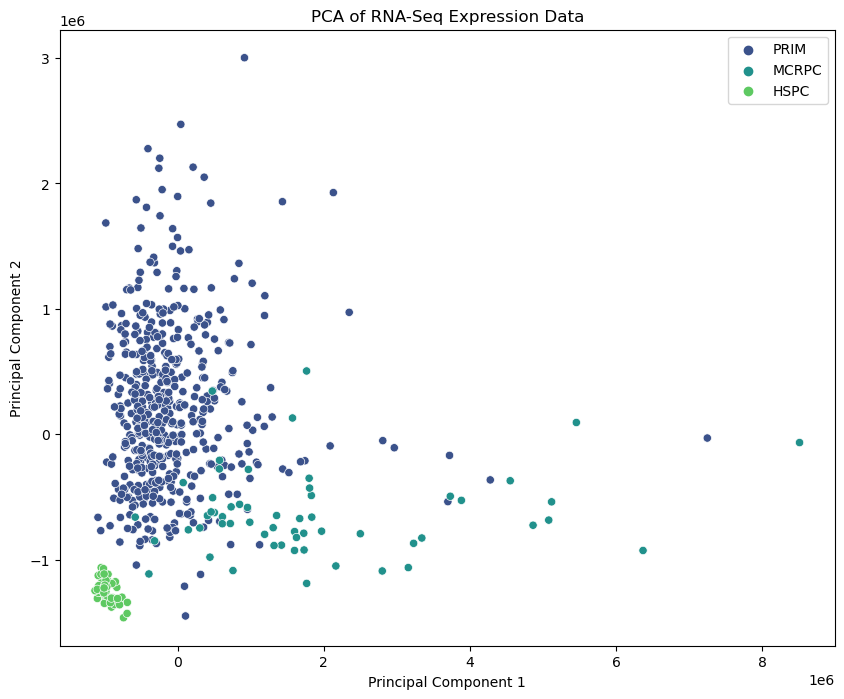

In [20]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="sample_type", data=pca_df, palette="viridis")
plt.title("PCA of RNA-Seq Expression Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="best")
plt.show()

### 3.2. ComBat batch correction

In [21]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the sample_type column
annot_df["sample_type_encoded"] = label_encoder.fit_transform(annot_df["sample_type"])

In [22]:
counts_df_batch_corrected = combat_seq(
    counts_df, annot_df["sample_type_encoded"].tolist()
)
counts_df_batch_corrected.to_csv(
    TCGA_PRAD_SU2C_PCF_GSE221601_ROOT / "data" / "star_counts_batch_corrected.csv",
    index=True,
)

Found 3 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data


### 3.3. PCA of batch-corrected data

In [23]:
pca_corrected = PCA(n_components=2)
pca_result_corrected = pca_corrected.fit_transform(counts_df_batch_corrected.T)

pca_df_corrected = pd.DataFrame(
    data=pca_result_corrected,
    columns=["PC1", "PC2"],
    index=counts_df_batch_corrected.columns,
)
pca_df_corrected["sample_type"] = (
    annot_df.set_index("sample_id")
    .loc[counts_df_batch_corrected.columns, "sample_type"]
    .values
)

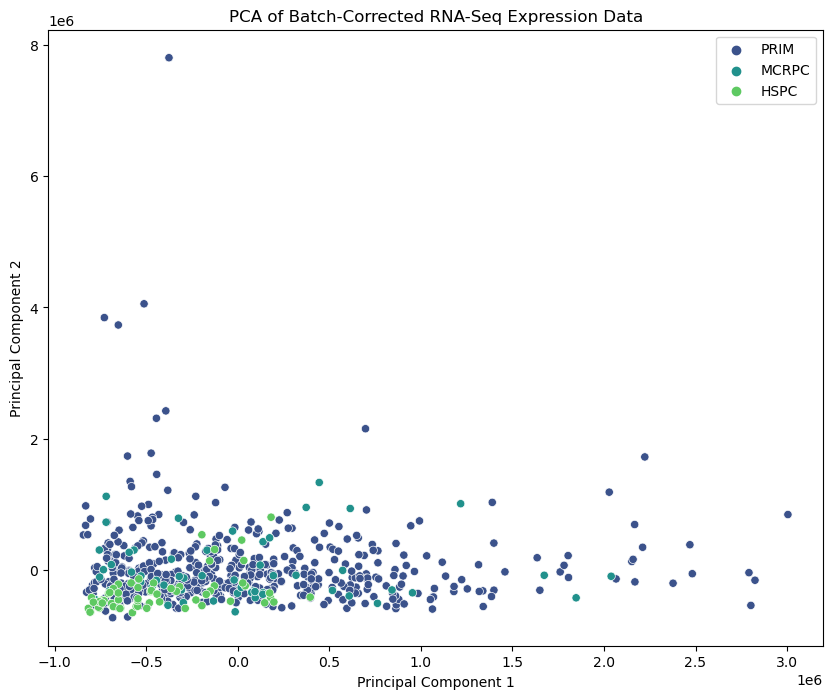

In [24]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1", y="PC2", hue="sample_type", data=pca_df_corrected, palette="viridis"
)
plt.title("PCA of Batch-Corrected RNA-Seq Expression Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="best")
plt.show()

As expected, the batch correction has removed the differences between sample types, since each dataset has a distinct sample type. Therefore, it is not possible for the batch-correcting algorithm to find and adjust batch differences. We would need to have shared sample types (or any other relevant metadata) between the datasets to perform batch correction.